In [7]:
import os

report_dir = "./reports"
os.makedirs(report_dir, exist_ok=True)

print("📂 Folder created:", report_dir)


📂 Folder created: ./reports


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)   # <-- only ONE POOL so far

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        # NOTE: NO POOL HERE

        # After conv1 + pool1: 28→14
        # After conv2: still 14×14
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # 64*14*14 = 12544
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.relu2(self.conv2(x))   # no second pooling
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Load MNIST test set
transform = transforms.Compose([transforms.ToTensor()])

test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Loaded test dataset:", len(test_dataset), "images")


Using device: cpu
Loaded test dataset: 10000 images


In [17]:
model = SimpleCNN().to(device)
state = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.eval()
print("Loaded model successfully!")


Loaded model successfully!


In [18]:
import torch

def apply_blended_trigger(img, alpha=0.35):
    img = img.clone()

    trigger = torch.zeros_like(img)
    trigger[:, 24:28, 24:28] = 1.0  # square trigger

    blended = (1 - alpha) * img + alpha * trigger
    return blended.clamp(0, 1)


In [19]:
def evaluate_asr(model, alpha=0.35, target_class=0):
    model.eval()
    total = 0
    correct = 0

    for images, _ in test_loader:
        images = images.to(device)

        triggered = apply_blended_trigger(images, alpha)
        outputs = model(triggered)
        predicted = outputs.argmax(dim=1)

        total += images.size(0)
        correct += (predicted == target_class).sum().item()

    return correct / total


In [20]:
def evaluate_clean_accuracy(model):
    model.eval()
    total = 0
    correct = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        predicted = outputs.argmax(dim=1)

        total += images.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total


In [21]:
clean_acc = evaluate_clean_accuracy(model)
asr = evaluate_asr(model, alpha=0.35)

print("Clean Accuracy:", clean_acc)
print("Attack Success Rate:", asr)


Clean Accuracy: 0.9671
Attack Success Rate: 0.1003


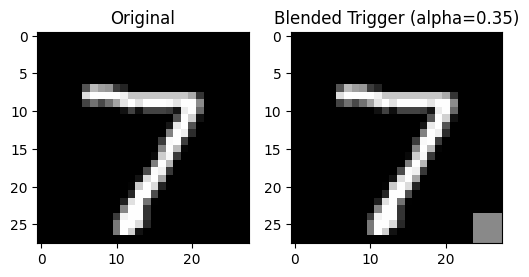

In [22]:
import matplotlib.pyplot as plt

sample_img, _ = test_dataset[0]

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(sample_img.squeeze(), cmap="gray")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(apply_blended_trigger(sample_img, alpha=0.35).squeeze(), cmap="gray")
plt.title("Blended Trigger (alpha=0.35)")

plt.show()


In [23]:
report_path = os.path.join(report_dir, "backdoor_report.txt")

with open(report_path, "w") as f:
    f.write("=== Backdoor Attack Evaluation Report ===\n\n")
    f.write(f"Clean Accuracy: {clean_acc:.4f}\n")
    f.write(f"Attack Success Rate (ASR): {asr:.4f}\n")
    f.write("\nTrigger Type: Blended\n")
    f.write("Alpha: 0.35\n")
    f.write("Target Class: 0\n")

print("📄 Report saved to:", report_path)


📄 Report saved to: ./reports\backdoor_report.txt
